<a href="https://colab.research.google.com/github/skyshine460/music_genre/blob/main/submission_musicgenre_25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# LightGBMモデル

In [14]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix

import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [15]:
df_train = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/test.csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/genre_labels.csv")

In [16]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [17]:
# ジャンル名を表示
df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

# tempoを数値に変換（中央値、対数）
df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)
df["log_tempo"] = np.log(df["tempo"])

# regionをワンホットエンコーディング
df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"}).astype(float)], axis=1)

# 欠損値の個数をカラム化
df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

In [18]:
# 欠損値を補間(kNN-mean)
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

numeric_columns =  [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]

# MinMaxScalerのインスタンスを作成
scaler = MinMaxScaler()

# スケーリングを実行
df_scaled_array = scaler.fit_transform(df[numeric_columns])

# 補間を行うためのKNNImputerを設定
imputer = KNNImputer(n_neighbors=2)

# k-NN補間を使用して欠損値を補完
df_imputed_array = imputer.fit_transform(df_scaled_array)

# 補完されたデータを元のスケールに逆変換
df_imputed_original = scaler.inverse_transform(df_imputed_array)

# 補完されたデータをDataFrameに戻す
df_imputed = pd.DataFrame(df_imputed_original, columns=numeric_columns)

# merged_dfの特定のカラムをdf_imputedで置き換える
df[numeric_columns] = df_imputed

# 欠損値の確認
print(df.isnull().sum())

index                  0
genre                  0
popularity             0
duration_ms            0
acousticness           0
positiveness           0
danceability           0
loudness               0
energy                 0
liveness               0
speechiness            0
instrumentalness       0
tempo                  0
region                 0
genre_name          4046
log_tempo              0
region_A               0
region_B               0
region_C               0
region_D               0
region_E               0
region_F               0
region_G               0
region_H               0
region_I               0
region_J               0
region_K               0
region_L               0
region_M               0
region_N               0
region_O               0
region_P               0
region_Q               0
region_R               0
region_S               0
region_T               0
region_unknown         0
num_nans               0
dtype: int64


In [19]:
# 各カラムを正規化
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [20]:
df.columns

Index(['index', 'genre', 'popularity', 'duration_ms', 'acousticness',
       'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
       'speechiness', 'instrumentalness', 'tempo', 'region', 'genre_name',
       'log_tempo', 'region_A', 'region_B', 'region_C', 'region_D', 'region_E',
       'region_F', 'region_G', 'region_H', 'region_I', 'region_J', 'region_K',
       'region_L', 'region_M', 'region_N', 'region_O', 'region_P', 'region_Q',
       'region_R', 'region_S', 'region_T', 'region_unknown', 'num_nans',
       'standardscaled_popularity', 'standardscaled_duration_ms',
       'standardscaled_acousticness', 'standardscaled_positiveness',
       'standardscaled_danceability', 'standardscaled_loudness',
       'standardscaled_energy', 'standardscaled_liveness',
       'standardscaled_speechiness', 'standardscaled_instrumentalness',
       'standardscaled_log_tempo', 'standardscaled_num_nans'],
      dtype='object')

In [21]:
def grouping_calculation(df, features_colc, group_col):
    for col in features_colc:
        # ジャンルごとの平均値と標準偏差を計算
        group_stats = df.groupby(group_col)[col].agg(['min', 'max', 'mean', 'std']).reset_index()
        group_stats.rename(columns={'min': col+'_min_'+group_col, 'max': col+'_max_'+group_col, 'mean': col+'_mean_'+group_col, 'std': col+'_std_'+group_col}, inplace=True)

        # 元のデータフレームにマージ
        df = pd.merge(df, group_stats, on=group_col, how='left')

        # 最小、最大、平均値との差の絶対値を計算
        df[col+'_diff_mean'] = abs(df[col] - df[col+'_mean_'+group_col])
        df[col+'_diff_min'] = abs(df[col] - df[col+'_min_'+group_col])
        df[col+'_diff_max'] = abs(df[col] - df[col+'_max_'+group_col])


        # 標準化を計算
        df[col+'_z'] = (df[col] - df[col+'_mean_'+group_col]) / df[col+'_std_'+group_col]

        # q1とq3を計算
        group_qstats = df.groupby(group_col)[col].agg([
            ('Q1', lambda x: x.quantile(0.25)),  # 第1四分位数
            ('Q3', lambda x: x.quantile(0.75))   # 第3四分位数
        ]).reset_index()

        # 四分位範囲 (IQR) を計算
        group_qstats['IQR'] = group_qstats['Q3'] - group_qstats['Q1']
        group_qstats.rename(columns={'Q1': col+'_q1_'+group_col, 'Q3': col+'_q3_'+group_col, 'IQR': col+'_iqr_'+group_col}, inplace=True)

        # 元のデータフレームにマージ
        df = pd.merge(df, group_qstats, on=group_col, how='left')

    return df


In [22]:
features_colc = ['standardscaled_popularity', 'standardscaled_duration_ms',
       'standardscaled_acousticness', 'standardscaled_positiveness',
       'standardscaled_danceability', 'standardscaled_loudness',
       'standardscaled_energy', 'standardscaled_liveness',
       'standardscaled_speechiness', 'standardscaled_instrumentalness',
       'standardscaled_log_tempo', 'standardscaled_num_nans']

df = grouping_calculation(df, features_colc, "region")
df.head(10)

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region,genre_name,log_tempo,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,region_K,region_L,region_M,region_N,region_O,region_P,region_Q,region_R,region_S,region_T,region_unknown,num_nans,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,standardscaled_log_tempo,standardscaled_num_nans,standardscaled_popularity_min_region,standardscaled_popularity_max_region,standardscaled_popularity_mean_region,standardscaled_popularity_std_region,standardscaled_popularity_diff_mean,standardscaled_popularity_diff_min,standardscaled_popularity_diff_max,standardscaled_popularity_z,standardscaled_popularity_q1_region,standardscaled_popularity_q3_region,standardscaled_popularity_iqr_region,standardscaled_duration_ms_min_region,standardscaled_duration_ms_max_region,standardscaled_duration_ms_mean_region,standardscaled_duration_ms_std_region,standardscaled_duration_ms_diff_mean,standardscaled_duration_ms_diff_min,standardscaled_duration_ms_diff_max,standardscaled_duration_ms_z,standardscaled_duration_ms_q1_region,standardscaled_duration_ms_q3_region,standardscaled_duration_ms_iqr_region,standardscaled_acousticness_min_region,standardscaled_acousticness_max_region,standardscaled_acousticness_mean_region,standardscaled_acousticness_std_region,standardscaled_acousticness_diff_mean,standardscaled_acousticness_diff_min,standardscaled_acousticness_diff_max,standardscaled_acousticness_z,standardscaled_acousticness_q1_region,standardscaled_acousticness_q3_region,standardscaled_acousticness_iqr_region,standardscaled_positiveness_min_region,standardscaled_positiveness_max_region,standardscaled_positiveness_mean_region,standardscaled_positiveness_std_region,standardscaled_positiveness_diff_mean,standardscaled_positiveness_diff_min,standardscaled_positiveness_diff_max,standardscaled_positiveness_z,standardscaled_positiveness_q1_region,standardscaled_positiveness_q3_region,standardscaled_positiveness_iqr_region,standardscaled_danceability_min_region,standardscaled_danceability_max_region,standardscaled_danceability_mean_region,standardscaled_danceability_std_region,standardscaled_danceability_diff_mean,standardscaled_danceability_diff_min,standardscaled_danceability_diff_max,standardscaled_danceability_z,standardscaled_danceability_q1_region,standardscaled_danceability_q3_region,standardscaled_danceability_iqr_region,standardscaled_loudness_min_region,standardscaled_loudness_max_region,standardscaled_loudness_mean_region,standardscaled_loudness_std_region,standardscaled_loudness_diff_mean,standardscaled_loudness_diff_min,standardscaled_loudness_diff_max,standardscaled_loudness_z,standardscaled_loudness_q1_region,standardscaled_loudness_q3_region,standardscaled_loudness_iqr_region,standardscaled_energy_min_region,standardscaled_energy_max_region,standardscaled_energy_mean_region,standardscaled_energy_std_region,standardscaled_energy_diff_mean,standardscaled_energy_diff_min,standardscaled_energy_diff_max,standardscaled_energy_z,standardscaled_energy_q1_region,standardscaled_energy_q3_region,standardscaled_energy_iqr_region,standardscaled_liveness_min_region,standardscaled_liveness_max_region,standardscaled_liveness_mean_region,standardscaled_liveness_std_region,standardscaled_liveness_diff_mean,standardscaled_liveness_diff_min,standardscaled_liveness_diff_max,standardscaled_liveness_z,standardscaled_liveness_q1_region,standardscaled_liveness_q3_region,standardscaled_liveness_iqr_region,standardscaled_speechiness_min_region,standardscaled_speechiness_max_region,standardscaled_speechiness_mean_region,standardscaled_speechiness_std_region,standardscaled_speechiness_diff_mean,sta

In [23]:
pip install category_encoders

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.0/82.0 kB 7.3 MB/s eta 0:00:00


In [24]:
import category_encoders as ce

# 'region' カラムに対して CountEncoder を適用
encoder = ce.CountEncoder()
df_encoded = encoder.fit_transform(df["region"])

# 結果を 'CE_' プレフィックスを付けて追加
df = pd.concat([df, df_encoded.add_prefix("CE_")], axis=1)

# df の最初の数行を表示
df.head()

,index,genre,popularity,duration_ms,acousticness,positiveness,danceability,loudness,energy,liveness,speechiness,instrumentalness,tempo,region,genre_name,log_tempo,region_A,region_B,region_C,region_D,region_E,region_F,region_G,region_H,region_I,region_J,region_K,region_L,region_M,region_N,region_O,region_P,region_Q,region_R,region_S,region_T,region_unknown,num_nans,standardscaled_popularity,standardscaled_duration_ms,standardscaled_acousticness,standardscaled_positiveness,standardscaled_danceability,standardscaled_loudness,standardscaled_energy,standardscaled_liveness,standardscaled_speechiness,standardscaled_instrumentalness,standardscaled_log_tempo,standardscaled_num_nans,standardscaled_popularity_min_region,standardscaled_popularity_max_region,standardscaled_popularity_mean_region,standardscaled_popularity_std_region,standardscaled_popularity_diff_mean,standardscaled_popularity_diff_min,standardscaled_popularity_diff_max,standardscaled_popularity_z,standardscaled_popularity_q1_region,standardscaled_popularity_q3_region,standardscaled_popularity_iqr_region,standardscaled_duration_ms_min_region,standardscaled_duration_ms_max_region,standardscaled_duration_ms_mean_region,standardscaled_duration_ms_std_region,standardscaled_duration_ms_diff_mean,standardscaled_duration_ms_diff_min,standardscaled_duration_ms_diff_max,standardscaled_duration_ms_z,standardscaled_duration_ms_q1_region,standardscaled_duration_ms_q3_region,standardscaled_duration_ms_iqr_region,standardscaled_acousticness_min_region,standardscaled_acousticness_max_region,standardscaled_acousticness_mean_region,standardscaled_acousticness_std_region,standardscaled_acousticness_diff_mean,standardscaled_acousticness_diff_min,standardscaled_acousticness_diff_max,standardscaled_acousticness_z,standardscaled_acousticness_q1_region,standardscaled_acousticness_q3_region,standardscaled_acousticness_iqr_region,standardscaled_positiveness_min_region,standardscaled_positiveness_max_region,standardscaled_positiveness_mean_region,standardscaled_positiveness_std_region,standardscaled_positiveness_diff_mean,standardscaled_positiveness_diff_min,standardscaled_positiveness_diff_max,standardscaled_positiveness_z,standardscaled_positiveness_q1_region,standardscaled_positiveness_q3_region,standardscaled_positiveness_iqr_region,standardscaled_danceability_min_region,standardscaled_danceability_max_region,standardscaled_danceability_mean_region,standardscaled_danceability_std_region,standardscaled_danceability_diff_mean,standardscaled_danceability_diff_min,standardscaled_danceability_diff_max,standardscaled_danceability_z,standardscaled_danceability_q1_region,standardscaled_danceability_q3_region,standardscaled_danceability_iqr_region,standardscaled_loudness_min_region,standardscaled_loudness_max_region,standardscaled_loudness_mean_region,standardscaled_loudness_std_region,standardscaled_loudness_diff_mean,standardscaled_loudness_diff_min,standardscaled_loudness_diff_max,standardscaled_loudness_z,standardscaled_loudness_q1_region,standardscaled_loudness_q3_region,standardscaled_loudness_iqr_region,standardscaled_energy_min_region,standardscaled_energy_max_region,standardscaled_energy_mean_region,standardscaled_energy_std_region,standardscaled_energy_diff_mean,standardscaled_energy_diff_min,standardscaled_energy_diff_max,standardscaled_energy_z,standardscaled_energy_q1_region,standardscaled_energy_q3_region,standardscaled_energy_iqr_region,standardscaled_liveness_min_region,standardscaled_liveness_max_region,standardscaled_liveness_mean_region,standardscaled_liveness_std_region,standardscaled_liveness_diff_mean,standardscaled_liveness_diff_min,standardscaled_liveness_diff_max,standardscaled_liveness_z,standardscaled_liveness_q1_region,standardscaled_liveness_q3_region,standardscaled_liveness_iqr_region,standardscaled_speechiness_min_region,standardscaled_speechiness_max_region,standardscaled_speechiness_mean_region,standardscaled_speechiness_std_region,standardscaled_speechiness_diff_mean,sta

In [25]:
# object型をカテゴリ型に変換する
for col in df.columns:
    if df[col].dtype == "object":  # object型の列を探す
        df[col] = df[col].astype("category")  # カテゴリ型に変換

df_train, df_test = split_train_test(df)
target = df_train["genre"]

In [26]:
df_train.columns.tolist()

['index',
 'genre',
 'popularity',
 'duration_ms',
 'acousticness',
 'positiveness',
 'danceability',
 'loudness',
 'energy',
 'liveness',
 'speechiness',
 'instrumentalness',
 'tempo',
 'region',
 'genre_name',
 'log_tempo',
 'region_A',
 'region_B',
 'region_C',
 'region_D',
 'region_E',
 'region_F',
 'region_G',
 'region_H',
 'region_I',
 'region_J',
 'region_K',
 'region_L',
 'region_M',
 'region_N',
 'region_O',
 'region_P',
 'region_Q',
 'region_R',
 'region_S',
 'region_T',
 'region_unknown',
 'num_nans',
 'standardscaled_popularity',
 'standardscaled_duration_ms',
 'standardscaled_acousticness',
 'standardscaled_positiveness',
 'standardscaled_danceability',
 'standardscaled_loudness',
 'standardscaled_energy',
 'standardscaled_liveness',
 'standardscaled_speechiness',
 'standardscaled_instrumentalness',
 'standardscaled_log_tempo',
 'standardscaled_num_nans',
 'standardscaled_popularity_min_region',
 'standardscaled_popularity_max_region',
 'standardscaled_popularity_mean_regi

In [27]:
N_CLASSES = 11
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()

features_numerical = [
 'popularity',
 'duration_ms',
 'acousticness',
 'positiveness',
 'danceability',
 'loudness',
 'energy',
 'liveness',
 'speechiness',
 'instrumentalness',
 'log_tempo',
 'region_A',
 'region_B',
 'region_C',
 'region_D',
 'region_E',
 'region_F',
 'region_G',
 'region_H',
 'region_I',
 'region_J',
 'region_K',
 'region_L',
 'region_M',
 'region_N',
 'region_O',
 'region_P',
 'region_Q',
 'region_R',
 'region_S',
 'region_T',
 'region_unknown',
 'num_nans',
 'standardscaled_popularity',
 'standardscaled_duration_ms',
 'standardscaled_acousticness',
 'standardscaled_positiveness',
 'standardscaled_danceability',
 'standardscaled_loudness',
 'standardscaled_energy',
 'standardscaled_liveness',
 'standardscaled_speechiness',
 'standardscaled_instrumentalness',
 'standardscaled_log_tempo',
 'standardscaled_num_nans',

 'standardscaled_popularity_mean_region',
 'standardscaled_popularity_std_region',
 'standardscaled_popularity_diff_mean',
 'standardscaled_popularity_diff_min',
 'standardscaled_popularity_diff_max',
 'standardscaled_popularity_z',
 'standardscaled_popularity_iqr_region',

 'standardscaled_duration_ms_mean_region',
 'standardscaled_duration_ms_std_region',
 'standardscaled_duration_ms_diff_mean',
 'standardscaled_duration_ms_diff_min',
 'standardscaled_duration_ms_diff_max',
 'standardscaled_duration_ms_z',
 'standardscaled_duration_ms_iqr_region',

 'standardscaled_acousticness_mean_region',
 'standardscaled_acousticness_std_region',
 'standardscaled_acousticness_diff_mean',
 'standardscaled_acousticness_diff_min',
 'standardscaled_acousticness_diff_max',
 'standardscaled_acousticness_z',
 'standardscaled_acousticness_iqr_region',

 'standardscaled_positiveness_mean_region',
 'standardscaled_positiveness_std_region',
 'standardscaled_positiveness_diff_mean',
 'standardscaled_positiveness_diff_min',
 'standardscaled_positiveness_diff_max',
 'standardscaled_positiveness_z',
 'standardscaled_positiveness_iqr_region',

 'standardscaled_danceability_mean_region',
 'standardscaled_danceability_std_region',
 'standardscaled_danceability_diff_mean',
 'standardscaled_danceability_diff_min',
 'standardscaled_danceability_diff_max',
 'standardscaled_danceability_z',
 'standardscaled_danceability_iqr_region',

 'standardscaled_loudness_mean_region',
 'standardscaled_loudness_std_region',
 'standardscaled_loudness_diff_mean',
 'standardscaled_loudness_diff_min',
 'standardscaled_loudness_diff_max',
 'standardscaled_loudness_z',
 'standardscaled_loudness_iqr_region',

 'standardscaled_energy_mean_region',
 'standardscaled_energy_std_region',
 'standardscaled_energy_diff_mean',
 'standardscaled_energy_diff_min',
 'standardscaled_energy_diff_max',
 'standardscaled_energy_z',
 'standardscaled_energy_iqr_region',

 'standardscaled_liveness_mean_region',
 'standardscaled_liveness_std_region',
 'standardscaled_liveness_diff_mean',
 'standardscaled_liveness_diff_min',
 'standardscaled_liveness_diff_max',
 'standardscaled_liveness_z',
 'standardscaled_liveness_iqr_region',

 'standardscaled_speechiness_mean_region',
 'standardscaled_speechiness_std_region',
 'standardscaled_speechiness_diff_mean',
 'standardscaled_speechiness_diff_min',
 'standardscaled_speechiness_diff_max',
 'standardscaled_speechiness_z',
 'standardscaled_speechiness_iqr_region',

 'standardscaled_instrumentalness_mean_region',
 'standardscaled_instrumentalness_std_region',
 'standardscaled_instrumentalness_diff_mean',
 'standardscaled_instrumentalness_diff_min',
 'standardscaled_instrumentalness_diff_max',
 'standardscaled_instrumentalness_z',
 'standardscaled_instrumentalness_iqr_region',

 'standardscaled_log_tempo_mean_region',
 'standardscaled_log_tempo_std_region',
 'standardscaled_log_tempo_diff_mean',
 'standardscaled_log_tempo_diff_min',
 'standardscaled_log_tempo_diff_max',
 'standardscaled_log_tempo_z',
 'standardscaled_log_tempo_iqr_region',

 'standardscaled_num_nans_mean_region',
 'standardscaled_num_nans_std_region',
 'standardscaled_num_nans_diff_mean',
 'standardscaled_num_nans_diff_min',
 'standardscaled_num_nans_diff_max',
 'standardscaled_num_nans_z',
 'standardscaled_num_nans_iqr_region',

 'CE_region'
]
features_categorical = ['region']
features = features_numerical + features_categorical





------------------------------ fold 0 ------------------------------


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 0 F1 score: 0.53970

------------------------------ fold 1 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 1 F1 score: 0.65251

------------------------------ fold 2 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 2 F1 score: 0.64651

------------------------------ fold 3 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 3 F1 score: 0.49193

------------------------------ fold 4 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 4 F1 score: 0.63132

------------------------------ fold 5 ------------------------------


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 5 F1 score: 0.59414

------------------------------ fold 6 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 6 F1 score: 0.61737

------------------------------ fold 7 ------------------------------


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Fold 7 F1 score: 0.54352

------------------------------ fold 8 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 8 F1 score: 0.57688

------------------------------ fold 9 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 9 F1 score: 0.55153

------------------------------ fold 10 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 10 F1 score: 0.47602

------------------------------ fold 11 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 11 F1 score: 0.56920

------------------------------ fold 12 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 12 F1 score: 0.57003

------------------------------ fold 13 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 13 F1 score: 0.51032

------------------------------ fold 14 ------------------------------
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf


/usr/local/lib/python3.10/dist-packages/lightgbm/engine.py:204: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Fold 14 F1 score: 0.55957


Fold-wise F1 scores:
  Fold 0: 0.53970
  Fold 1: 0.65251
  Fold 2: 0.64651
  Fold 3: 0.49193
  Fold 4: 0.63132
  Fold 5: 0.59414
  Fold 6: 0.61737
  Fold 7: 0.54352
  Fold 8: 0.57688
  Fold 9: 0.55153
  Fold 10: 0.47602
  Fold 11: 0.56920
  Fold 12: 0.57003
  Fold 13: 0.51032
  Fold 14: 0.55957
CV score
  f1:  0.58423

              precision    recall  f1-score   support

           0       0.85      0.53      0.65        32
           1       0.62      0.23      0.34       205
           2       0.72      0.36      0.48       191
           3       0.78      0.70      0.74       362
           4       0.74      0.44      0.56        45
           5       0.69      0.37      0.48       126
           6       0.60      0.18      0.28        50
           7       0.63      0.55      0.59       334
           8       0.66      0.80      0.72      1305
           9       0.84      0.88      0.86        59
          10       0.71      0.79      0.75      1337

 

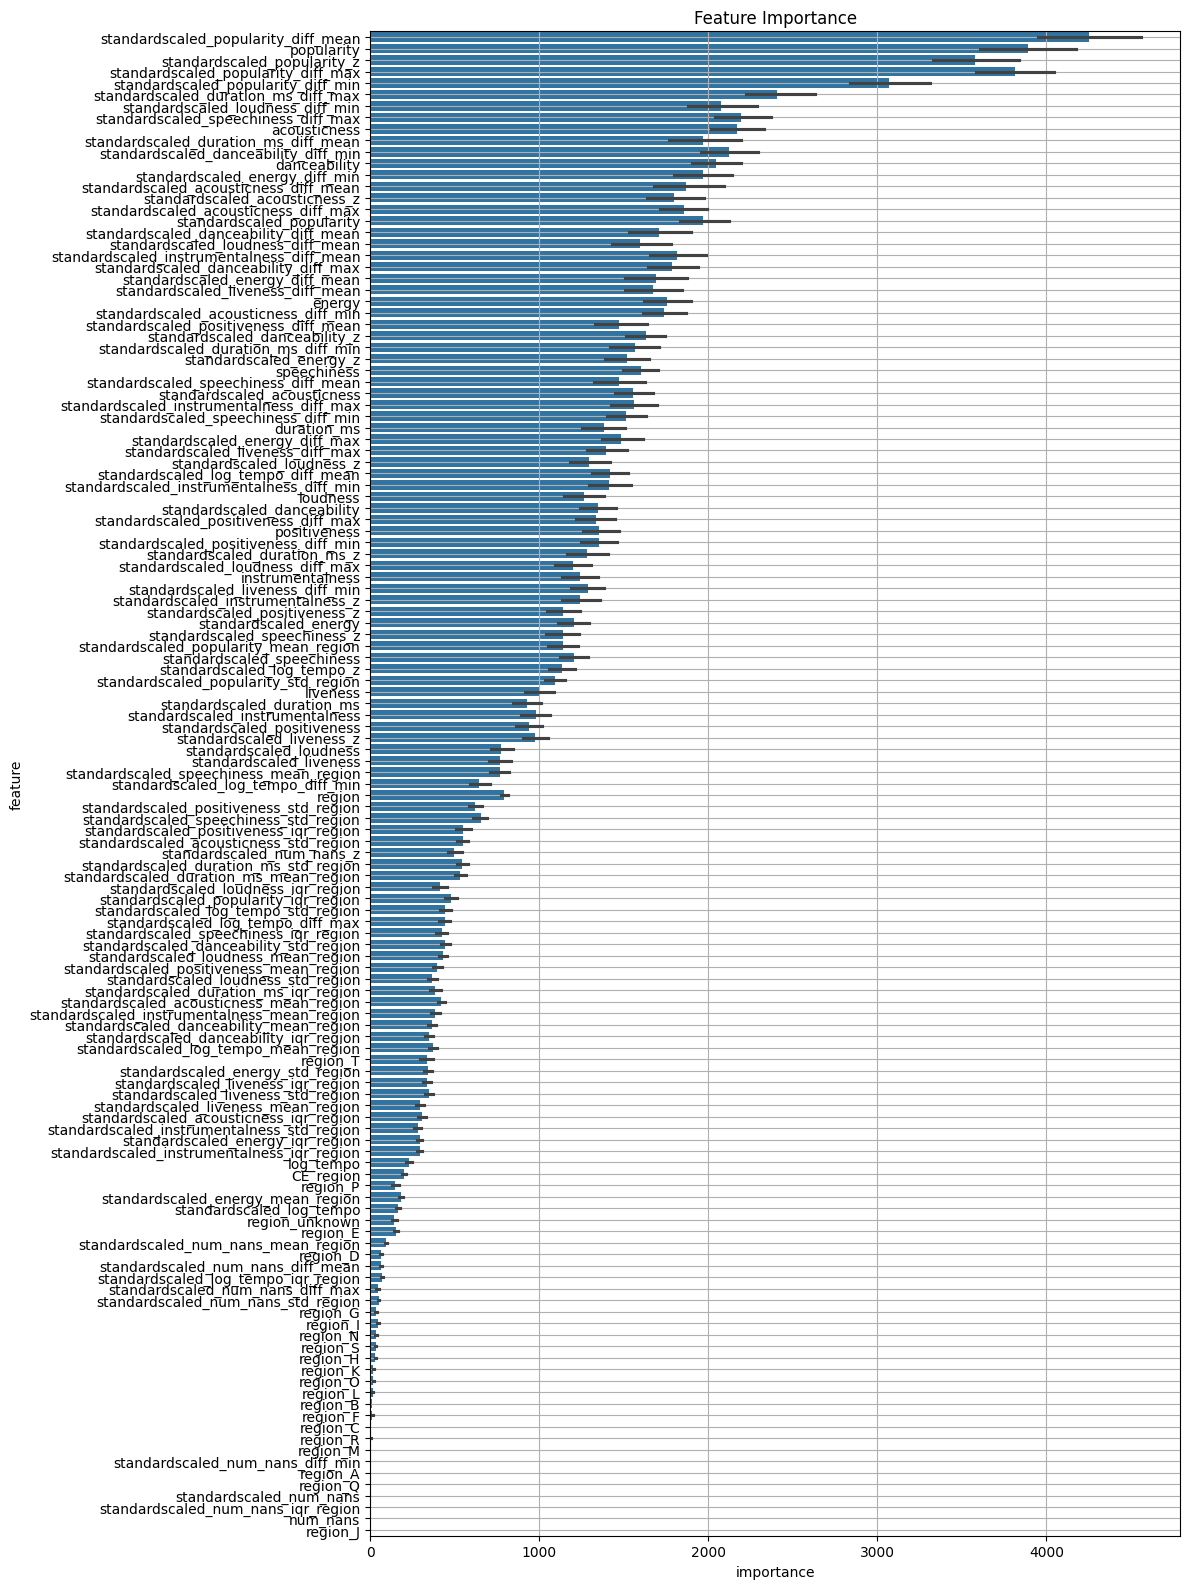

In [28]:
from sklearn.metrics import f1_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

# 各foldごとのF1スコアを格納するリスト
fold_f1_scores = []

# foldに分けて学習と評価を行う
for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    # 学習データと評価データを元の学習データから抽出
    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)

    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)


    # lightGBMモデル用のデータセット
    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )

    # # 各クラスのサンプル数を計算
    # class_counts = np.array([np.sum(target == i) for i in range(N_CLASSES)])

    # # クラスの重みを計算（クラス数に基づいて調整）
    # scale_pos_weight = class_counts.max() / class_counts

    # モデルパラメータ設定
    lgb_params = {
        "objective": "multiclass",
        "learning_rate": 0.01,
        "min_data_in_leaf": 40,
        "verbosity": 0,
        "n_estimators": 10000,
        "num_leaves": 31,
        "random_state": 42,
        "n_jobs": -1,
        # "importance_type": "gain",
        "colsample_bytree": .5,
        "num_class": 11,
        # "class_weight":"balanced",  # class weight: 逆ラベル頻度
        "is_unbalance": True
    }

    # モデル学習の最大回数
    num_round = 999999999

    # モデル作成
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_round,
        valid_sets=[lgb_train, lgb_valid],
        callbacks=[
            lgb.early_stopping(stopping_rounds=50, verbose=False),
            lgb.log_evaluation(0)],
    )

    # 最適な学習回数を設定
    prediction_round = model.best_iteration

    # 最適な学習回数に基づいて予測
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    # 各foldのF1スコアを計算
    fold_f1 = f1_score(target_val, oof[indexes_val].argmax(1), average="macro")
    fold_f1_scores.append(fold_f1)
    print(f"Fold {fold_} F1 score: {fold_f1:.5f}")

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

# 各foldのF1スコアを表示
print("\nFold-wise F1 scores:")
for i, f1 in enumerate(fold_f1_scores):
    print(f"  Fold {i}: {f1:.5f}")

# 最終的なF1スコア（全体）
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

# Feature importanceの可視化
plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("Feature Importance")
plt.grid()
plt.tight_layout()
plt.show()


<ipython-input-29-3b046d3a59ea>:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)


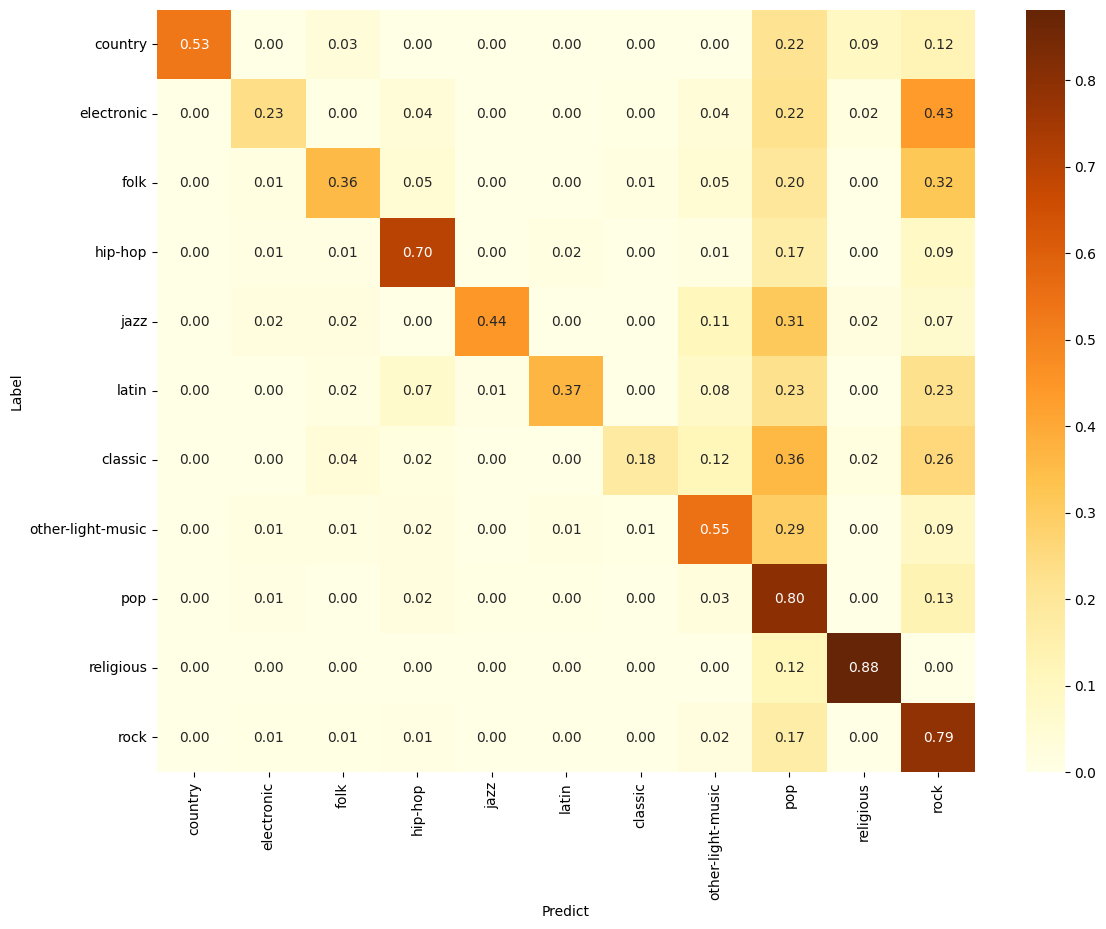

In [29]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

df_test["prediction"] = predictions.argmax(1)
oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()

In [30]:
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submission_musicgenre_23.csv", header=None, index=False)
df1 = df_submission.copy()

,index,genre
0,4046,8
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,8
9,4055,10


# kNNモデル

In [31]:
from pathlib import Path

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [32]:
df_train = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/test.csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/genre_labels.csv")

In [33]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [34]:
# feature engineering

df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()


print(df.isnull().sum())

index                  0
genre                  0
popularity             0
duration_ms            0
acousticness           1
positiveness          24
danceability          19
loudness               0
energy                 1
liveness               9
speechiness           19
instrumentalness       3
tempo                  0
region                 0
genre_name          4046
region_A               0
region_B               0
region_C               0
region_D               0
region_E               0
region_F               0
region_G               0
region_H               0
region_I               0
region_J               0
region_K               0
region_L               0
region_M               0
region_N               0
region_O               0
region_P               0
region_Q               0
region_R               0
region_S               0
region_T               0
region_unknown         0
num_nans               0
dtype: int64


In [35]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import KNNImputer

numeric_columns =  [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]

# MinMaxScalerのインスタンスを作成
scaler = MinMaxScaler()

# スケーリングを実行
df_scaled_array = scaler.fit_transform(df[numeric_columns])

# 補間を行うためのKNNImputerを設定
imputer = KNNImputer(n_neighbors=2)

# k-NN補間を使用して欠損値を補完
df_imputed_array = imputer.fit_transform(df_scaled_array)

# 補完されたデータを元のスケールに逆変換
df_imputed_original = scaler.inverse_transform(df_imputed_array)

# 補完されたデータをDataFrameに戻す
df_imputed = pd.DataFrame(df_imputed_original, columns=numeric_columns)

# merged_dfの特定のカラムをdf_imputedで置き換える
df[numeric_columns] = df_imputed

# 欠損値の確認
print(df.isnull().sum())

index                  0
genre                  0
popularity             0
duration_ms            0
acousticness           0
positiveness           0
danceability           0
loudness               0
energy                 0
liveness               0
speechiness            0
instrumentalness       0
tempo                  0
region                 0
genre_name          4046
region_A               0
region_B               0
region_C               0
region_D               0
region_E               0
region_F               0
region_G               0
region_H               0
region_I               0
region_J               0
region_K               0
region_L               0
region_M               0
region_N               0
region_O               0
region_P               0
region_Q               0
region_R               0
region_S               0
region_T               0
region_unknown         0
num_nans               0
dtype: int64


In [36]:
# feature scaling

df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]

In [37]:

df_train, df_test = split_train_test(df)
target = df_train["genre"]

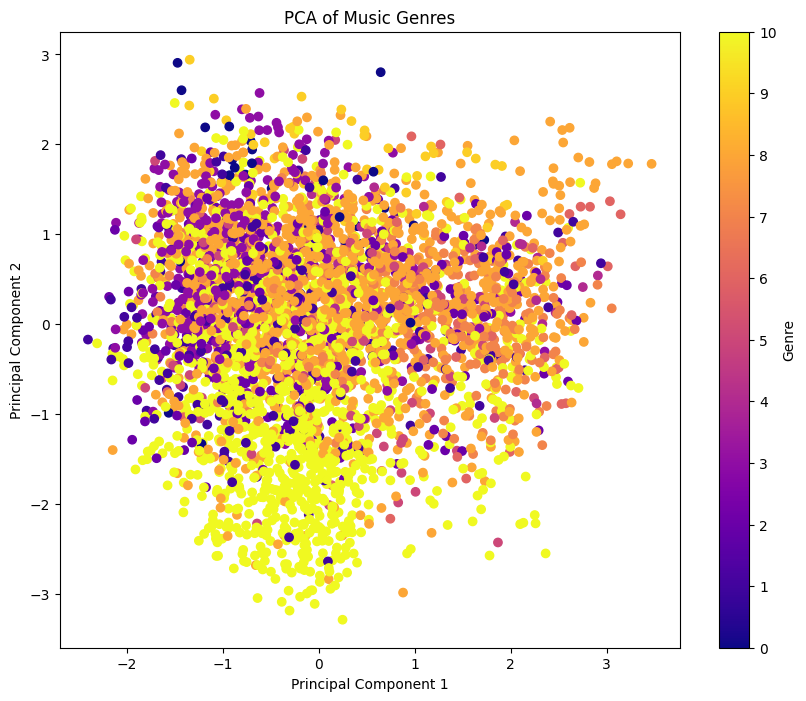

(4046, 53)


In [38]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# 特徴量のリスト
feature_num = [
            'popularity', 'acousticness', 'positiveness'
]

# 特徴量とターゲットを抽出
train_cleaned = df_train[feature_num + ['genre']]

# 特徴量とターゲット（ジャンル）を用意
train = train_cleaned.drop(columns=['genre'])  # 特徴量
y_train = train_cleaned['genre']  # ジャンルラベル

# データの標準化
scaler = StandardScaler()
df_train_scaled = scaler.fit_transform(train)

# PCAの実行
pca = PCA(n_components=2)  # 2次元に削減
pca_train_result = pca.fit_transform(df_train_scaled)

# PCAの結果をデータフレームに変換
pca_train_df = pd.DataFrame(data=pca_train_result, columns=['PC1', 'PC2'])
pca_train_df['genre'] = y_train.values  # ジャンルラベルを追加

# 可視化
plt.figure(figsize=(10, 8))
scatter = plt.scatter(pca_train_df['PC1'], pca_train_df['PC2'],
                      c=pca_train_df['genre'].astype('category').cat.codes, cmap='plasma')
plt.title('PCA of Music Genres')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(scatter, ticks=range(len(np.unique(y_train))), label='Genre')
plt.show()

# トレーニングデータにPCAの結果を追加
df_train = pd.concat([df_train.reset_index(drop=True), pca_train_df.reset_index(drop=True)], axis=1)
print(df_train.shape)

In [39]:
# テストデータの標準化（トレーニングデータのスケーラーを使用）
test_num = df_test[feature_num]
df_test_scaled = scaler.transform(test_num)

# テストデータにPCAを適用
pca_test_result = pca.transform(df_test_scaled)

# 結果をデータフレームに変換
pca_test_df = pd.DataFrame(data=pca_test_result, columns=['PC1', 'PC2'])

# テストデータにPCAの結果を追加（必要に応じて）
df_test = pd.concat([df_test.reset_index(drop=True), pca_test_df.reset_index(drop=True)], axis=1)

df_test.shape

(4046, 52)

In [40]:

# feature weights

features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans', 'PC1', 'PC2'
]

dict_feature_weights = {}

for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness', 'PC1', 'PC2'
]:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

feature_weights = np.array([dict_feature_weights[col] for col in features])

In [41]:

# parameters

N_CLASSES = 11
n_neighbors = 6

f1_score=0.6554092072734369

              precision    recall  f1-score   support

           0       0.83      0.59      0.69        32
           1       0.55      0.38      0.45       205
           2       0.68      0.61      0.64       191
           3       0.81      0.71      0.76       362
           4       0.74      0.62      0.67        45
           5       0.68      0.52      0.59       126
           6       0.66      0.38      0.48        50
           7       0.62      0.55      0.58       334
           8       0.70      0.79      0.74      1305
           9       0.75      0.88      0.81        59
          10       0.77      0.80      0.78      1337

    accuracy                           0.72      4046
   macro avg       0.71      0.62      0.66      4046
weighted avg       0.72      0.72      0.72      4046



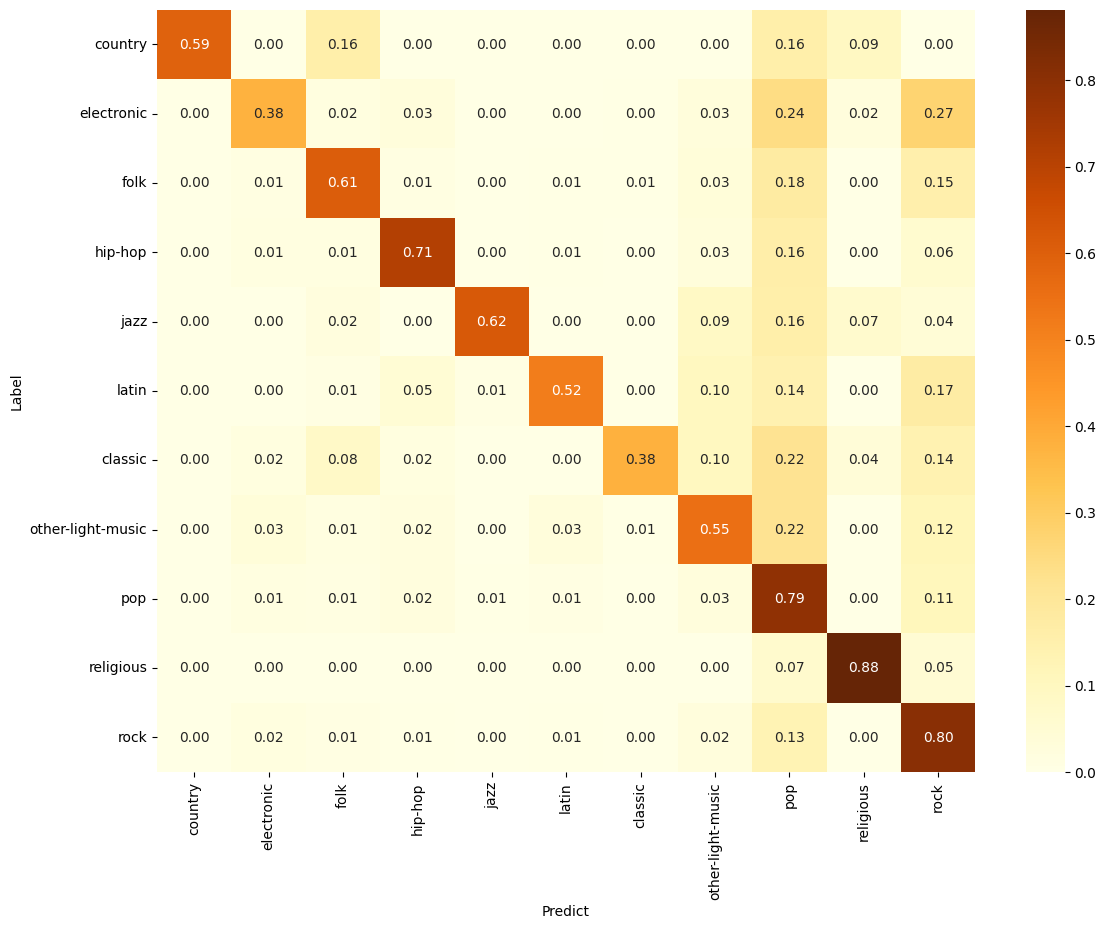

In [42]:
# cross validation

def calc_loo_cv_score():  # leave-one-out
    model = KNeighborsClassifier(n_neighbors + 1, weights="distance")
    X = df_train[features].fillna(0.0).values * feature_weights
    model.fit(X, target)
    distances, indexes = model.kneighbors(X)
    distances = distances[:, 1:]
    indexes = indexes[:, 1:]
    labels = target.values[indexes]
    preds = np.array([np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)]).argmax(1)
    score = f1_score(target, preds, average="macro")
    print(f"f1_score={score}\n")
    print(classification_report(target, preds))


    def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):
        conf = confusion_matrix(y_true=y_true,
                                y_pred=pred_label,
                                normalize='true')

        n_labels = len(conf)
        size = n_labels * height
        fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
        sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
        ax.set_ylabel('Label')
        ax.set_xlabel('Predict')

        if labels is not None:
            ax.set_yticklabels(labels)
            ax.set_xticklabels(labels)
            ax.tick_params('y', labelrotation=0)
            ax.tick_params('x', labelrotation=90)

        return fig

    fig = visualize_confusion_matrix(target, preds, labels=df_genre_labels["genre"])
    fig.show()

calc_loo_cv_score()

In [43]:

# prediction for test data

model = KNeighborsClassifier(n_neighbors, weights="distance")
X_train = df_train[features].fillna(0.0).values * feature_weights
X_test = df_test[features].fillna(0.0).values * feature_weights
model.fit(X_train, target)
df_test["prediction"] = model.predict(X_test)
df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
df_submission.head(10)

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


In [44]:
df_submission.to_csv("submission_musicgenre_14.csv", index=False, header=False)
df2 = df_submission.copy()

# kNN+lightGBM

In [45]:

from pathlib import Path
import warnings

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, f1_score, confusion_matrix
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt


# warnings.simplefilter('ignore', pd.core.common.SettingWithCopyWarning)
# warnings.simplefilter('ignore', UserWarning)


N_CLASSES = 11

In [46]:
df_train = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/test.csv")
df_sample_sub = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/sample_submit.csv", header=None)
df_sample_sub.columns = ["index", "genre"]
df_genre_labels = pd.read_csv("/content/drive/MyDrive/楽曲のジャンル推定チャレンジ！！（SOTA：SIGNATE Student Cup 2021春）/提供データ/genre_labels.csv")


In [47]:
def merge_train_test(df_train, df_test):
    if "genre" not in df_test.columns.tolist():
        df_test["genre"] = -100
    res = pd.concat([df_train, df_test])
    res.reset_index(inplace=True, drop=True)
    return res

def split_train_test(df):
    df_train = df[df["genre"] != -100]
    df_test = df[df["genre"] == -100]
    df_train.reset_index(inplace=True, drop=True)
    df_test.reset_index(inplace=True, drop=True)
    return df_train, df_test

df = merge_train_test(df_train, df_test)

In [49]:
#  feature engineering

df["genre_name"] = df["genre"].map(dict(df_genre_labels[["labels", "genre"]].values))

df["tempo"] = df["tempo"].map(lambda x: sum(map(int, x.split("-"))) / 2)

df = pd.concat([df, pd.get_dummies(df["region"]).rename(columns={"unknown": "region_unknown"})], axis=1)

df["num_nans"] = 0
for col in [
    "acousticness",
    "positiveness",
    "danceability",
    "energy",
    "liveness",
    "speechiness",
    "instrumentalness",
]:
    df["num_nans"] += df[col].isna()

class CountEncoder:
    def fit(self, series):
        self.counts = series.groupby(series).count()
        return self

    def transform(self, series):
        return series.map(self.counts).fillna(0)

    def fit_transform(self, series):
        return self.fit(series).transform(series)
columns_count_enc = ["region"]
for col in columns_count_enc:
    df["countenc_" + col] = CountEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "countenc_" + col] = np.nan


columns_label_enc = ["region"]
for col in columns_count_enc:
    df["labelenc_" + col] = LabelEncoder().fit_transform(df[col])
    df.loc[df[col].isna().values, "labelenc_" + col] = np.nan


class GroupFeatureExtractor:
    EX_TRANS_METHODS = ["deviation", "zscore"]

    def __init__(self, group_key, group_values, agg_methods):
        self.group_key = group_key
        self.group_values = group_values

        self.ex_trans_methods = [m for m in agg_methods if m in self.EX_TRANS_METHODS]
        self.agg_methods = [m for m in agg_methods if m not in self.ex_trans_methods]
        self.df_agg = None

    def fit(self, df_train, y=None):
        if not self.agg_methods:
            return
        dfs = []
        for agg_method in self.agg_methods:
            if callable(agg_method):
                agg_method_name = agg_method.__name__
            else:
                agg_method_name = agg_method
            df_agg = (df_train[[self.group_key] + self.group_values].groupby(self.group_key).agg(agg_method))
            df_agg.columns = self._get_column_names(agg_method_name)
            dfs.append(df_agg)
        self.df_agg = pd.concat(dfs, axis=1).reset_index()

    def transform(self, df_eval):
        key = self.group_key
        if self.agg_methods:
            df_features = pd.merge(df_eval[[self.group_key]], self.df_agg, on=self.group_key, how="left")
        else:
            df_features = df_eval[[self.group_key]].copy()
        if self.ex_trans_methods:
            if "deviation" in self.ex_trans_methods:
                df_features[self._get_agg_column_names("deviation")] = df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")
            if "zscore" in self.ex_trans_methods:
                df_features[self._get_column_names("zscore")] = (df_eval[self.group_values] - df_eval[[key]+self.group_values].groupby(key).transform("mean")) \
                                                                / (df_eval[[key]+self.group_values].groupby(key).transform("std") + 1e-8)
        df_features.drop(self.group_key, axis=1, inplace=True)
        return df_features

    def _get_column_names(self, method):
        return [f"agg_{method}_{col}_grpby_{self.group_key}" for col in self.group_values]

    def fit_transform(self, df_train, y=None):
        self.fit(df_train, y=y)
        return self.transform(df_train)

df["log_tempo"] = np.log(df["tempo"])
gfe = GroupFeatureExtractor(
    "region",
    ['popularity', 'duration_ms', 'acousticness', 'positiveness', 'danceability', 'loudness', 'energy', 'liveness', 'speechiness', 'instrumentalness', 'log_tempo'],
    ["zscore"]
)
df = pd.concat([df, gfe.fit_transform(df)], axis=1)


class KNNFeatureExtractor:
    def __init__(self, n_neighbors=5):
        self.knn = KNeighborsClassifier(n_neighbors + 1)

    def fit(self, X, y):
        self.knn.fit(X, y)
        self.y = y if isinstance(y, np.ndarray) else np.array(y)
        return self

    def transform(self, X, is_train_data):
        distances, indexes = self.knn.kneighbors(X)
        distances = distances[:, 1:] if is_train_data else distances[:, :-1]
        indexes = indexes[:, 1:] if is_train_data else indexes[:, :-1]
        labels = self.y[indexes]
        score_columns = [f"knn_score_class{c:02d}" for c in range(N_CLASSES)]
        df_knn = pd.DataFrame(
            [np.bincount(labels_, distances_, N_CLASSES) for labels_, distances_ in zip(labels, 1.0 / distances)],
            columns=score_columns
        )
        df_knn["max_knn_scores"] = df_knn.max(1)
        for col in score_columns:
            df_knn[f"sub_max_knn_scores_{col}"] = df_knn["max_knn_scores"] - df_knn[col]
        for i, col1 in enumerate(score_columns):
            for j, col2 in enumerate(score_columns[i+1:], i+1):
                if {i, j} & {8, 10}:
                    df_knn[f"sub_{col1}_{col2}"] = df_knn[col1] - df_knn[col2]
        df_knn["sum_knn_scores"] = df_knn.sum(1)

        return df_knn


# feature scaling

df["log_tempo"] = np.log(df["tempo"])
for col in [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'log_tempo', 'num_nans',
]:
    df["standardscaled_" + col] = StandardScaler().fit_transform(df[[col]])[:, 0]



df_train, df_test = split_train_test(df)
target = df_train["genre"]


In [50]:
# parameters

# def lgb_metric(preds, data):
#     pred_labels = preds.reshape(N_CLASSES, -1).argmax(axis=0)
#     score = f1_score(data.get_label(), pred_labels, average="macro")
#     return "macro_f1", score, True

learning_rate = 0.01

lgb_params = {
    "objective": "multiclass",
    "num_class": N_CLASSES,
    #"metric": "None",
    "learning_rate": learning_rate,
    "num_leaves": 3,
    "min_data_in_leaf": 40,
    #"colsample_bytree": 1.0,
    #"feature_fraction": 1.0,
    #"bagging_freq": 0,
    #"bagging_fraction": 1.0,
    "verbosity": 0,
    "seed": 42,
}

knn_n_neighbors = 6


# parameters - knn feature weights

knn_features = [
   'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
   'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
   'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
   'region_S', 'region_T', 'region_unknown',
   'standardscaled_popularity', 'standardscaled_duration_ms',
   'standardscaled_acousticness', 'standardscaled_positiveness',
   'standardscaled_danceability', 'standardscaled_loudness',
   'standardscaled_energy', 'standardscaled_liveness',
   'standardscaled_speechiness', 'standardscaled_instrumentalness',
   'standardscaled_log_tempo', 'standardscaled_num_nans'
]

dict_feature_weights = {}

for col in [
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown'
]:
    dict_feature_weights[col] = 100.0

for col in [
    'standardscaled_duration_ms',
    'standardscaled_acousticness', 'standardscaled_positiveness',
    'standardscaled_danceability', 'standardscaled_loudness',
    'standardscaled_energy', 'standardscaled_liveness',
    'standardscaled_speechiness', 'standardscaled_instrumentalness'
]:
    dict_feature_weights[col] = 1.0

dict_feature_weights["standardscaled_popularity"] = 8.0
dict_feature_weights["standardscaled_log_tempo"] = 0.001
dict_feature_weights["standardscaled_num_nans"] = 100.0

knn_feature_weights = np.array([dict_feature_weights[col] for col in knn_features])


In [51]:
N_SPLITS = 15
SEED_SKF = 42
np.random.seed(42)

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED_SKF)
oof = np.zeros((len(df_train), N_CLASSES))
predictions = np.zeros((len(df_test), N_CLASSES))
df_feature_importance = pd.DataFrame()

features_numerical = [
    'popularity', 'duration_ms', 'acousticness',
    'positiveness', 'danceability', 'loudness', 'energy', 'liveness',
    'speechiness', 'instrumentalness', 'tempo',
    'region_A', 'region_B', 'region_C', 'region_D', 'region_E', 'region_F',
    'region_G', 'region_H', 'region_I', 'region_J', 'region_K', 'region_L',
    'region_M', 'region_N', 'region_O', 'region_P', 'region_Q', 'region_R',
    'region_S', 'region_T', 'region_unknown', 'countenc_region',
    'num_nans',
    'agg_zscore_popularity_grpby_region',
    'agg_zscore_duration_ms_grpby_region',
    'agg_zscore_acousticness_grpby_region',
    'agg_zscore_positiveness_grpby_region',
    'agg_zscore_danceability_grpby_region',
    'agg_zscore_loudness_grpby_region', 'agg_zscore_energy_grpby_region',
    'agg_zscore_liveness_grpby_region',
    'agg_zscore_speechiness_grpby_region',
    'agg_zscore_instrumentalness_grpby_region',
    'agg_zscore_log_tempo_grpby_region',
    'knn_score_class00', 'knn_score_class01',
    'knn_score_class02', 'knn_score_class03', 'knn_score_class04',
    'knn_score_class05', 'knn_score_class06', 'knn_score_class07',
    'knn_score_class08', 'knn_score_class09', 'knn_score_class10',
    'max_knn_scores',
    'sub_max_knn_scores_knn_score_class00',
    'sub_max_knn_scores_knn_score_class01',
    'sub_max_knn_scores_knn_score_class02',
    'sub_max_knn_scores_knn_score_class03',
    'sub_max_knn_scores_knn_score_class04',
    'sub_max_knn_scores_knn_score_class05',
    'sub_max_knn_scores_knn_score_class06',
    'sub_max_knn_scores_knn_score_class07',
    'sub_max_knn_scores_knn_score_class08',
    'sub_max_knn_scores_knn_score_class09',
    'sub_max_knn_scores_knn_score_class10',
    'sub_knn_score_class00_knn_score_class08',
    'sub_knn_score_class00_knn_score_class10',
    'sub_knn_score_class01_knn_score_class08',
    'sub_knn_score_class01_knn_score_class10',
    'sub_knn_score_class02_knn_score_class08',
    'sub_knn_score_class02_knn_score_class10',
    'sub_knn_score_class03_knn_score_class08',
    'sub_knn_score_class03_knn_score_class10',
    'sub_knn_score_class04_knn_score_class08',
    'sub_knn_score_class04_knn_score_class10',
    'sub_knn_score_class05_knn_score_class08',
    'sub_knn_score_class05_knn_score_class10',
    'sub_knn_score_class06_knn_score_class08',
    'sub_knn_score_class06_knn_score_class10',
    'sub_knn_score_class07_knn_score_class08',
    'sub_knn_score_class07_knn_score_class10',
    'sub_knn_score_class08_knn_score_class09',
    'sub_knn_score_class08_knn_score_class10',
    'sub_knn_score_class09_knn_score_class10',
    'sum_knn_scores'
]
features_categorical = ["labelenc_region"]
features = features_numerical + features_categorical

for fold_, (indexes_trn, indexes_val) in enumerate(skf.split(df_train.values, target.values)):
    print(f"------------------------------ fold {fold_} ------------------------------")

    df_trn = df_train.loc[indexes_trn].reset_index(drop=True)
    df_val = df_train.loc[indexes_val].reset_index(drop=True)
    target_trn = target.loc[indexes_trn].reset_index(drop=True)
    target_val = target.loc[indexes_val].reset_index(drop=True)

    # make knn features
    X = df_trn[knn_features].fillna(0.0).values * knn_feature_weights
    knn_feature_extractor = KNNFeatureExtractor(knn_n_neighbors).fit(X, target_trn)
    df_trn = pd.concat([df_trn, knn_feature_extractor.transform(X, is_train_data=True)], axis=1)
    X = df_val[knn_features].fillna(0.0).values * knn_feature_weights
    df_val = pd.concat([df_val, knn_feature_extractor.transform(X, is_train_data=False)], axis=1)
    X = df_test[knn_features].fillna(0.0).values * knn_feature_weights
    df_test_knn_features = knn_feature_extractor.transform(X, is_train_data=False)
    for col in df_test_knn_features.columns:
        df_test[col] = df_test_knn_features[col]

    lgb_params = {
        "objective": "multiclass",
        "num_class": 11,
        "learning_rate": 0.01,
        "num_leaves": 5,
        "min_data_in_leaf": 40,
        "verbosity": 0,
        "seed": 42
    }

    lgb_train = lgb.Dataset(
        df_trn.loc[:, features],
        label=target_trn,
        feature_name=features,
        categorical_feature=features_categorical
    )
    lgb_valid = lgb.Dataset(
        df_val.loc[:, features],
        label=target_val,
        feature_name=features,
        categorical_feature=features_categorical
    )

    # lgb_params["learning_rate"] = learning_rate + np.random.random() * 0.001  # おまじない
    num_round = 999999999
    model = lgb.train(
        lgb_params,
        lgb_train,
        num_round,
        valid_sets=[lgb_train, lgb_valid],
            callbacks=[
                lgb.early_stopping(stopping_rounds=50, verbose=False),
                lgb.log_evaluation(0)],
    )

    # cv
    prediction_round = model.best_iteration+150 if num_round >= 1e8 else num_round  # おまじない
    oof[indexes_val] = model.predict(df_val[features], num_iteration=prediction_round)

    # feature importance
    df_fold_importance = pd.DataFrame()
    df_fold_importance["feature"] = features
    df_fold_importance["importance"] = model.feature_importance()
    df_fold_importance["fold"] = fold_
    df_feature_importance = pd.concat([df_feature_importance, df_fold_importance], axis=0)

    # prediction for test data
    predictions += model.predict(df_test[features], num_iteration=prediction_round) / N_SPLITS
    print()

------------------------------ fold 0 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]
<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl


------------------------------ fold 1 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 2 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 3 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 4 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 5 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 6 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 7 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 8 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 9 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 10 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 11 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 12 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 13 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]



------------------------------ fold 14 ------------------------------


<ipython-input-51-96a144892daf>:86: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[col] = df_test_knn_features[col]


CV score
  f1:  0.67109

              precision    recall  f1-score   support

           0       0.87      0.62      0.73        32
           1       0.58      0.43      0.49       205
           2       0.70      0.58      0.64       191
           3       0.80      0.78      0.79       362
           4       0.72      0.62      0.67        45
           5       0.61      0.50      0.55       126
           6       0.63      0.38      0.47        50
           7       0.66      0.62      0.64       334
           8       0.72      0.79      0.76      1305
           9       0.86      0.85      0.85        59
          10       0.78      0.81      0.80      1337

    accuracy                           0.74      4046
   macro avg       0.72      0.64      0.67      4046
weighted avg       0.73      0.74      0.73      4046



<ipython-input-52-798c61f6630b>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test["prediction"] = predictions.argmax(1)


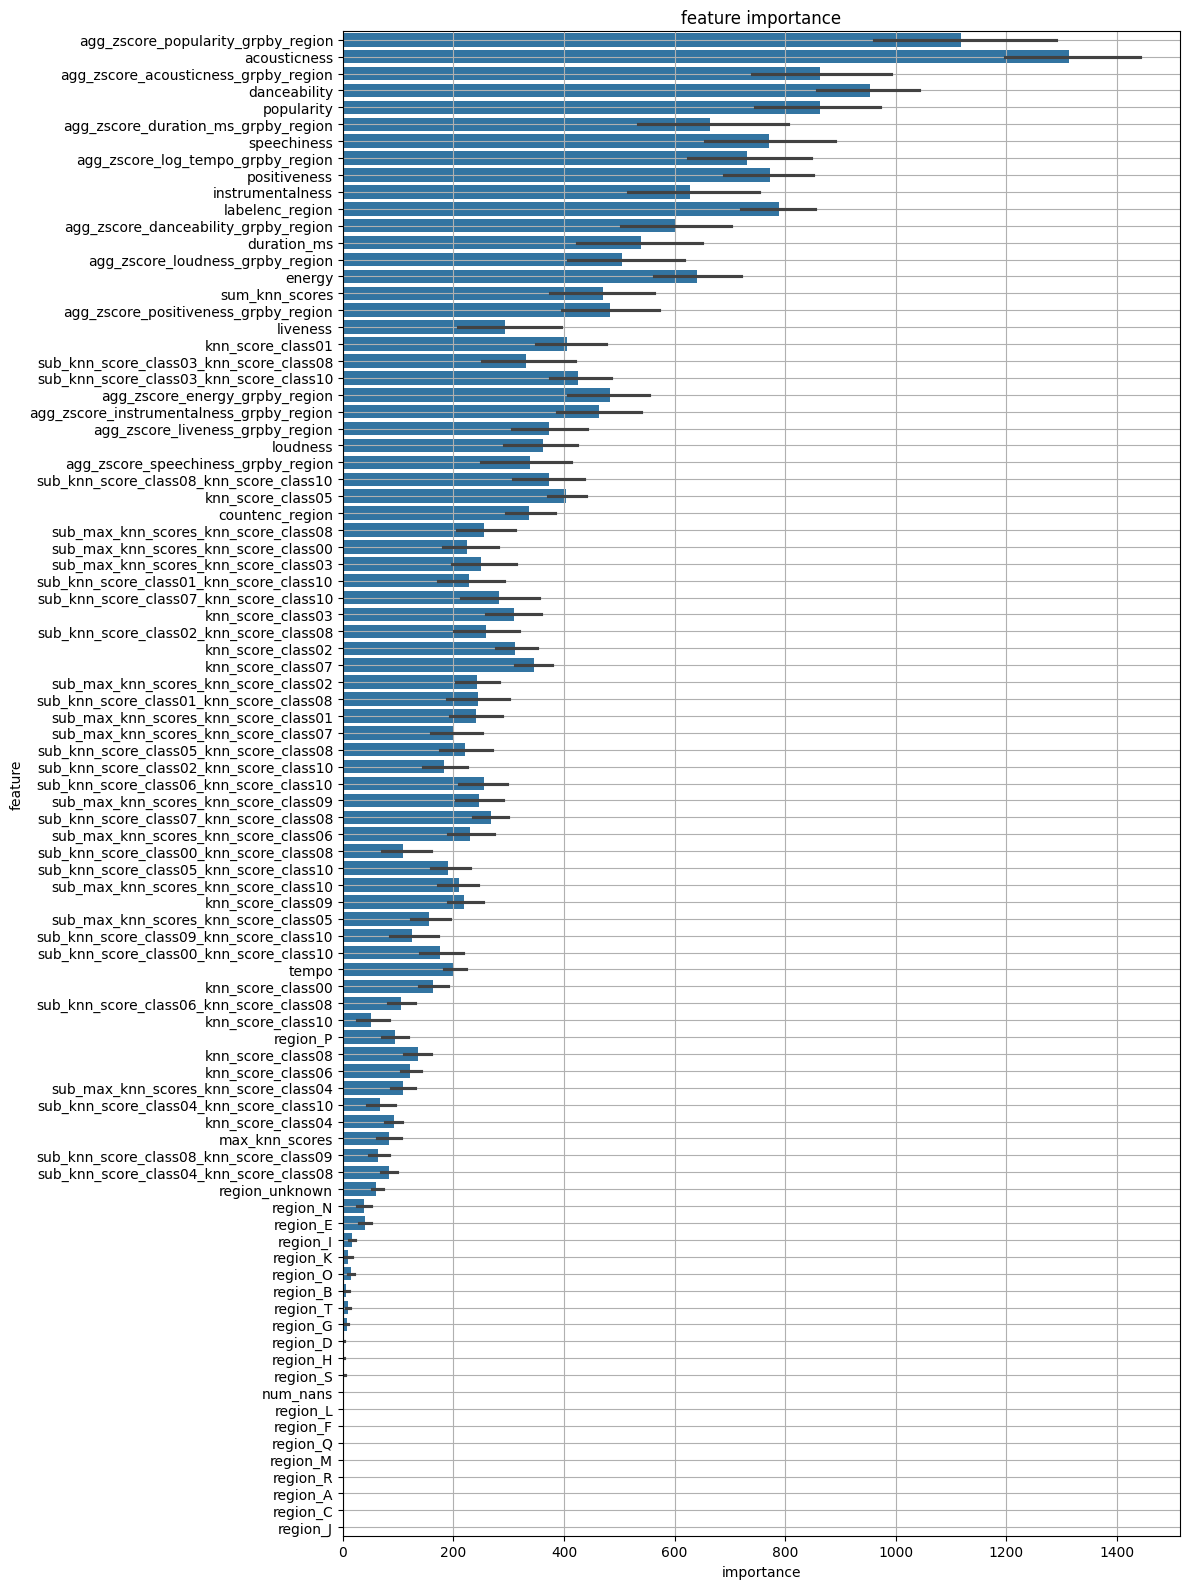

In [52]:
df_test["prediction"] = predictions.argmax(1)
score = f1_score(target, oof.argmax(1), average="macro")
print("CV score")
print(f"  f1: {score:8.5f}")
print()
print(classification_report(target, oof.argmax(1)))

plt.figure(figsize=(12, 16))
sns.barplot(x="importance", y="feature", data=df_feature_importance.sort_values(by="importance", ascending=False))
plt.title("feature importance")
plt.grid()
plt.tight_layout()
plt.show()

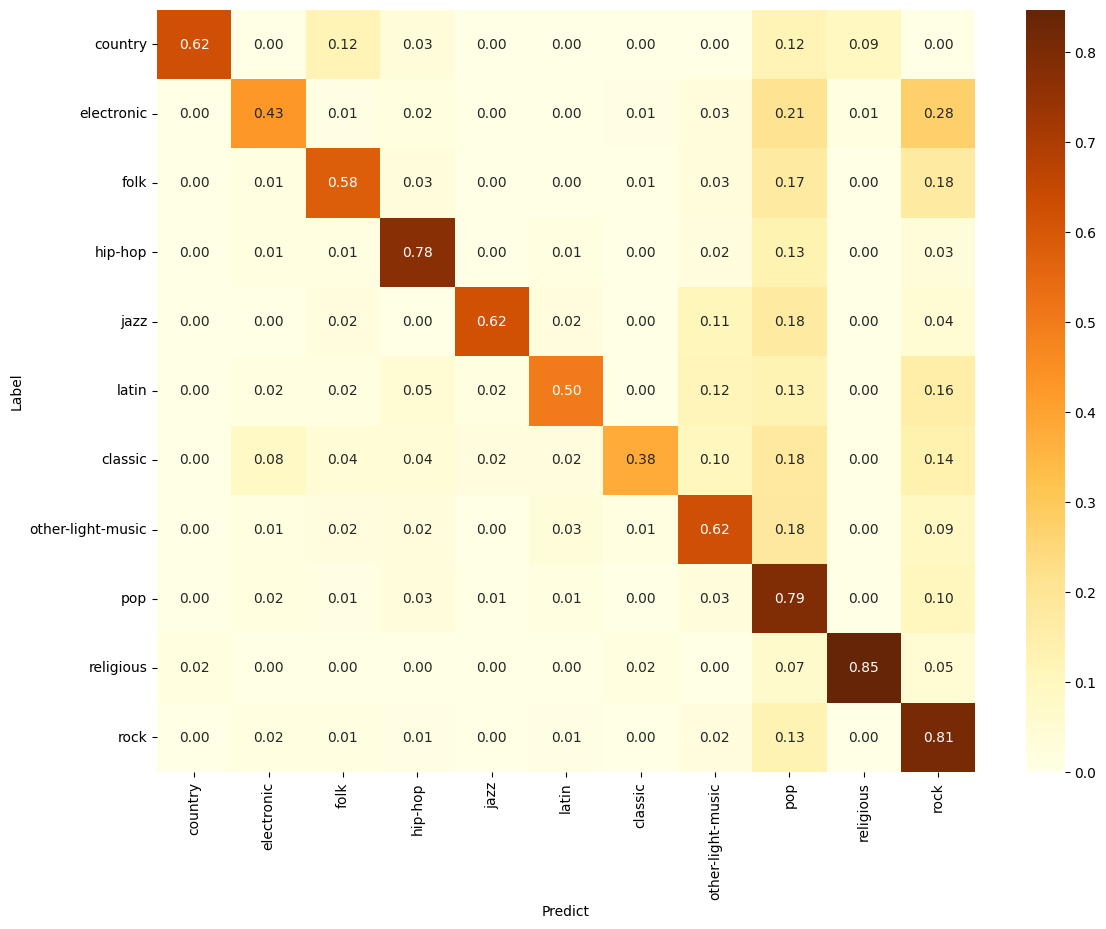

In [53]:
def visualize_confusion_matrix(y_true,
                               pred_label,
                               height=.6,
                               labels=None):  # from https://signate.jp/competitions/449/discussions/lgbm-baseline-lb06240
    conf = confusion_matrix(y_true=y_true,
                            y_pred=pred_label,
                            normalize='true')

    n_labels = len(conf)
    size = n_labels * height
    fig, ax = plt.subplots(figsize=(size * 2, size * 1.5))
    sns.heatmap(conf, cmap='YlOrBr', ax=ax, annot=True, fmt='.2f')
    ax.set_ylabel('Label')
    ax.set_xlabel('Predict')

    if labels is not None:
        ax.set_yticklabels(labels)
        ax.set_xticklabels(labels)
        ax.tick_params('y', labelrotation=0)
        ax.tick_params('x', labelrotation=90)

    return fig

oof_label = pd.Series(np.argmax(oof, axis=1))
fig = visualize_confusion_matrix(y_true=target, pred_label=oof_label, labels=df_genre_labels["genre"])
fig.show()

In [54]:

df_submission = df_sample_sub.copy()
df_submission["genre"] = df_submission["index"].map(dict(df_test[["index", "prediction"]].values))
assert not df_submission["genre"].isna().any()
display(df_submission.head(10))

# make submission file
df_submission.to_csv("submission_musicgenre_18.csv", header=None, index=False)
df3 = df_submission.copy()

,index,genre
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8
5,4051,7
6,4052,8
7,4053,8
8,4054,3
9,4055,10


# ensemble

In [55]:
df1.columns = ['ID', 'col1']
df2.columns = ['ID', 'col2']
df3.columns = ['ID', 'col3']

In [56]:
df = pd.merge(df1, df2, on='ID', how='inner')
df = pd.merge(df, df3, on='ID', how='inner')

In [57]:

# "submit" カラムを追加し、df1, df2, df3の多数決を取る
def majority_vote(row):
    # df1, df2, df3の各値をリストとして取り出す
    votes = [row['col1'], row['col2'], row['col3']]
    # 最も頻度が高い値を取得
    most_common = pd.Series(votes).mode().iloc[0]
    # 全てがバラバラ（多数決が決まらない）場合はdf3の値を採用
    if votes.count(most_common) == 1:
        return row['col3']
    return most_common

# 'submit' カラムに多数決結果を適用
df['submit'] = df.apply(majority_vote, axis=1)

# 結果を表示
df.head()

,ID,col1,col2,col3,submit
0,4046,8,7,7,7
1,4047,10,10,10,10
2,4048,10,10,10,10
3,4049,8,8,8,8
4,4050,8,8,8,8


In [58]:
submit_df = df[['ID', 'submit']].reset_index(drop=True)
submit_df.head()

,ID,submit
0,4046,7
1,4047,10
2,4048,10
3,4049,8
4,4050,8


In [59]:
submit_df.to_csv("submission_musicgenre_25.csv", index=False, header=False)